In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [2]:
def safelog(vals):
    return np.log(np.maximum(vals, 1e-10))
    
def normalize(vals):
    return vals / np.sum(vals, axis=1, keepdims=True)

def generate_lexicons(n_words, n_meanings):
        arrays =  np.array([list(map(int, list(np.binary_repr(i, width=n_words*n_meanings)))) 
                            for i in range(2**(n_words*n_meanings))])
        lexicons = arrays.reshape((2**(n_words*n_meanings), n_words, n_meanings))
        return lexicons[lexicons.sum(axis=1).min(axis=1) > 0]

In [162]:
class BaseRSA:
    def __init__(self, alpha, prior, C, contexts):
        self.contexts = contexts
        self.alpha = alpha
        self.prior = prior
        self.C = C

    @staticmethod
    def safelog(vals):
        with np.errstate(divide='ignore'):
            return np.log(vals)

    @staticmethod
    def normalize(vals):
        return np.nan_to_num(vals / np.sum(vals, axis=-1, keepdims=True))
    
    def L_0(self, L, c):
        return self.normalize(L * self.prior * self.contexts[c])
    
    def S_p(self, L, c):
        return self.normalize(np.exp(self.alpha * (self.safelog(self.L_0(L, c).transpose(0, 2, 1)) - self.C)))
    
    def L_p(self, L, c):
        return self.normalize(self.S_p(L, c).transpose(0, 2, 1) * self.prior * self.contexts[c])

class Agent(BaseRSA):
    def __init__(self, alpha, prior, C, n_words, n_meanings, contexts):
        super().__init__(alpha, prior, C, contexts)
        self.Lexicons = generate_lexicons(n_words, n_meanings)
        self.prob_lexicon = np.ones(len(self.Lexicons)) / len(self.Lexicons)
        self.n_words = n_words
        self.n_meanings = n_meanings
    
    def speaker(self, m, c):
        # index of the lexicon with the highest probability given prob_lexicon
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        return self.S_p(self.Lexicons, c)[lexicon_idx][m].argmax()
    
    def listener(self, w, c):
        # index of the lexicon with the highest probability given prob_lexicon
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        return self.L_p(self.Lexicons, c)[lexicon_idx][w].argmax()
    
    def update(self, w, m, c):
        # self.prob_lexicon = self.normalize(self.L_p(self.Lexicons, c)[:, w, m] * self.prob_lexicon)
        self.prob_lexicon = self.normalize(self.L_0(self.Lexicons, c)[:, w, m] * self.prob_lexicon + 1e-4)

In [196]:
prior = np.array([1, 4, 4])
prior = prior / np.sum(prior)
alpha = 10
C = np.array([0, 20])
contexts = np.array([[1, 1, 0], [1, 0, 1]])

In [197]:
def one_round(a, b, m, c):
    w = a.speaker(m, c)
    g = b.listener(w, c)
    if m == g:
        a.update(w, m, c)
        b.update(w, m, c)
    return m == g, w, g

In [198]:
posteriors = []
logs = defaultdict(lambda: defaultdict(dict))

for t in range(100):
    a = Agent(alpha, prior, C, 2, 3, contexts)
    b = Agent(alpha, prior, C, 2, 3, contexts)

    for _ in range(100):
        m = np.random.choice([0, 2])
        logs[t][_]['meaning'] = m
        # if meaning is 0, context is either 0 or 1, if 1, context is 0, if 2 context is 1
        c = np.random.choice([0, 1]) if m == 0 else m - 1
        logs[t][_]['context'] = c
        if _ % 2 == 0:
            tr, w, g = one_round(a, b, m, c)
            logs[t][_]['word'] = w
            logs[t][_]['guess'] = g
            logs[t][_]['correct'] = 1 if tr else 0
        else:
            tr, w, g = one_round(b, a, m, c)
            logs[t][_]['word'] = w
            logs[t][_]['guess'] = g
            logs[t][_]['correct'] = 1 if tr else 0

    posteriors.append(a.prob_lexicon)
    posteriors.append(b.prob_lexicon)

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_37659/3812182458.py:15: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(vals / np.sum(vals, axis=-1, keepdims=True))


In [199]:
# logs to df
df = pd.DataFrame.from_dict({(i,j): logs[i][j]
                            for i in logs.keys()
                            for j in logs[i].keys()},
                            orient='index').reset_index()
df.columns = ['trial', 'round', 'word', 'guess', 'meaning', 'context', 'correct']

In [200]:
# group rounds by 4
df['round_group'] = df['round'] // 4

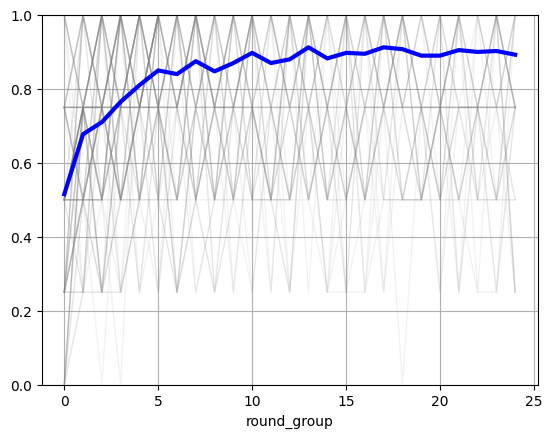

In [201]:
# plot every individual trial as a line in gray
for i in range(100):
    plt.plot(df[df['trial'] == i].groupby('round_group')['correct'].mean(), color='gray', alpha=0.1, linewidth=1)
df.groupby('round_group')['correct'].mean().plot(linewidth=3, color='blue')
plt.grid()
plt.ylim(0, 1)
plt.show()

In [202]:
posteriors = np.sum(posteriors, axis=0)
posteriors = posteriors / np.sum(posteriors)

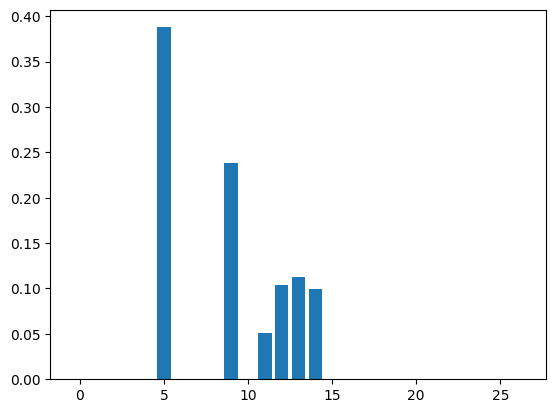

In [203]:
# plot the posterior distribution of the lexicons
plt.bar(np.arange(len(posteriors)), posteriors)
plt.show()

In [204]:
# get the lexicon with the highest probability
lexicon_idx = np.argmax(posteriors)
print(a.Lexicons[lexicon_idx])

[[0 1 1]
 [1 0 0]]


In [205]:
# print top 4 lexicons in the posterior distribution
for i in np.argsort(posteriors)[::-1][:2]:
    print(a.Lexicons[i])

[[0 1 1]
 [1 0 0]]
[[1 0 0]
 [0 1 1]]


In [206]:
df = pd.DataFrame(a.Lexicons[lexicon_idx], columns=['m1', 'm2', 'm3'], index=['w1', 'w2'])
# add row with prior
df.loc['prior'] = prior
# add column with costs (account for one new row)
df['costs'] = np.append(C, 0)
df

,m1,m2,m3,costs
w1,0.000000,1.000000,1.000000,0
w2,1.000000,0.000000,0.000000,20
prior,0.111111,0.444444,0.444444,0
